노트북 요약

- interaction을 통한 기본적인 모델링 진행
  - 사용하는 알고리즘 : svd
  - data : custom_movie_rating.txt

# **Interaction 기반 모델링 순서**

**1. 데이터 로딩 및 탐색** ✅ (현재 구현됨)
- 사용자-영화 평점 데이터 로드
- 기본 통계 확인 (사용자 수, 영화 수, 평점 수)

**2. 탐색적 데이터 분석 (EDA)** ✅ (일부 구현됨)
- 사용자별 평점 개수 분포
- 사용자별 평균 평점 분포
- 영화별 평점 개수 분포
- 평점 분포 (0.5, 1.0, ... 5.0)
- Sparsity(희소성) 확인

**3. 데이터 전처리**
- 최소 평점 개수 필터링 (cold start 문제 완화)
  - 평점이 너무 적은 사용자 제거
  - 평점이 너무 적은 영화 제거
- User ID와 Movie ID를 숫자 인덱스로 매핑

**4. Train/Test 데이터 분할**
- 시간 기반 분할 또는 랜덤 분할
- 일반적으로 80:20 또는 90:10 비율

**5. 모델 학습 (SVD 기반)**
- Surprise 라이브러리 사용
- SVD 파라미터 설정 (n_factors, n_epochs, lr_all, reg_all)
- GridSearch로 하이퍼파라미터 튜닝 (선택적)

**6. 모델 평가**
- RMSE, MAE 등의 metric 계산
- Train/Test 성능 비교

**7. 추천 생성**
- 사용자가 아직 평가하지 않은 영화에 대해 예측
- Top-N 추천 생성

**8. 결과 분석**
- 추천 영화 확인
- 다양성, 참신성 등 추가 지표 분석

현재 노트북은 **1단계와 2단계 초반**까지만 구현되어 있습니다. 다음 단계들을 구현해드릴까요?

# Load Data

In [1]:
import sys
import os

# 주피터 노트북 환경에서 __file__이 없으므로, 현재 워킹 디렉토리 기준으로 설정
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from data_scraping.common.data_loader import load_ratings_data
    
    
df_ratings = load_ratings_data()

In [2]:
df_ratings

,user_id,movie_id,movie_title,rating
0,ZBm5R0Mj7qd46,m5XKVDL,양자물리학,3.0
1,ZBm5R0Mj7qd46,m5Nn2GE,영화로운 작음,3.5
2,ZBm5R0Mj7qd46,mWvq0vZ,내 방,2.5
3,ZBm5R0Mj7qd46,mdKpyBk,성적표의 김민영,3.0
4,ZBm5R0Mj7qd46,mOopbwm,킹덤4: 대장군의 귀환,3.0
...,...,...,...,...
1979617,JZ4vBPRKVxRXO,mBOk88d,맨발의 기봉이,5.0
1979618,JZ4vBPRKVxRXO,mMO2zkO,"지금, 만나러 갑니다",4.0
1979619,JZ4vBPRKVxRXO,mP5moGO,벅스 라이프,5.0
1979620,JZ4vBPRKVxRXO,mdRLrvW,알 포인트,5.0


# EDA


[사용자별 평점 수 통계(describe)]
             count
count  2442.000000
mean    810.656020
std     680.058892
min       1.000000
25%     362.000000
50%     663.500000
75%    1084.500000
max    8090.000000


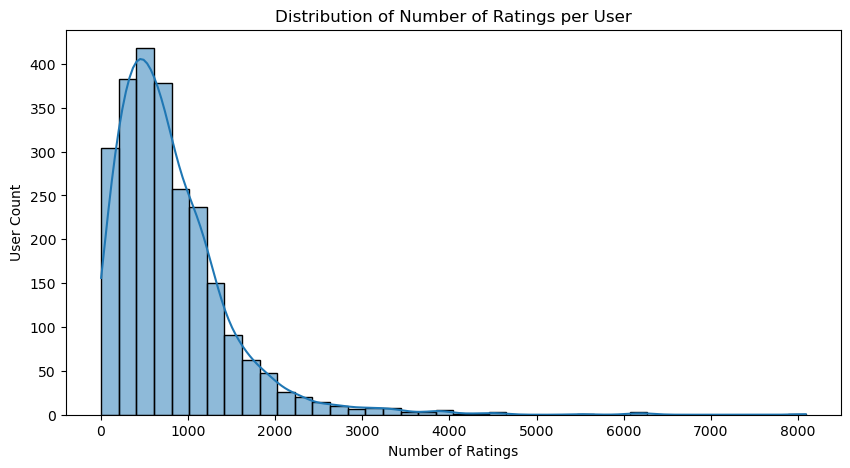


[사용자별 평균 평점 통계(describe)]
       mean_rating
count  2442.000000
mean      3.408043
std       0.386217
min       1.521008
25%       3.190982
50%       3.416551
75%       3.625494
max       5.000000


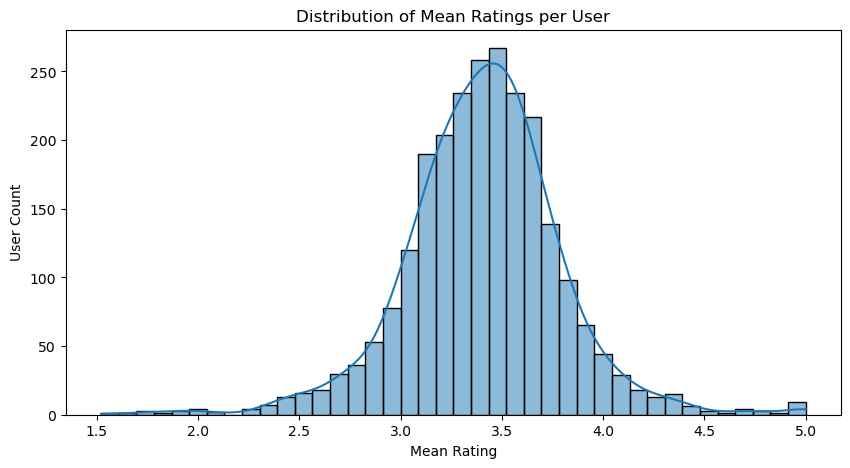


[영화별 평점 수 통계(describe)]
              count
count  42176.000000
mean      46.937168
std      158.821528
min        1.000000
25%        1.000000
50%        3.000000
75%       15.000000
max     1978.000000


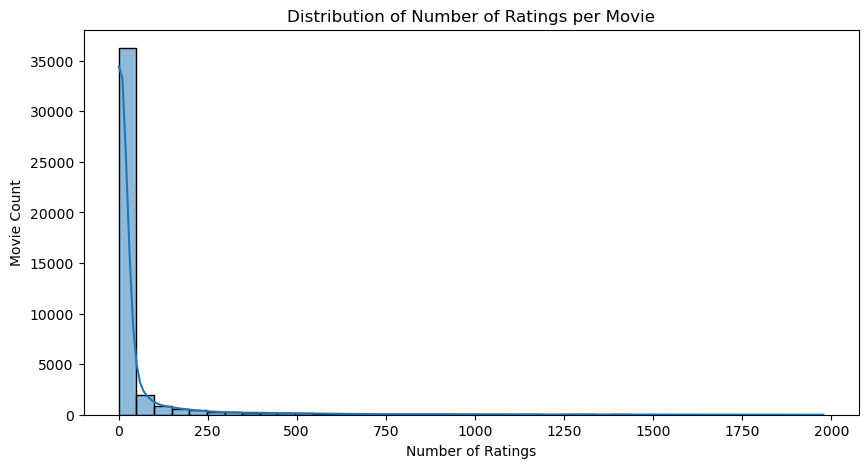


[영화별 평균 평점 통계(describe)]
        mean_rating
count  42176.000000
mean       2.941682
std        0.831165
min        0.500000
25%        2.500000
50%        3.000000
75%        3.500000
max        5.000000


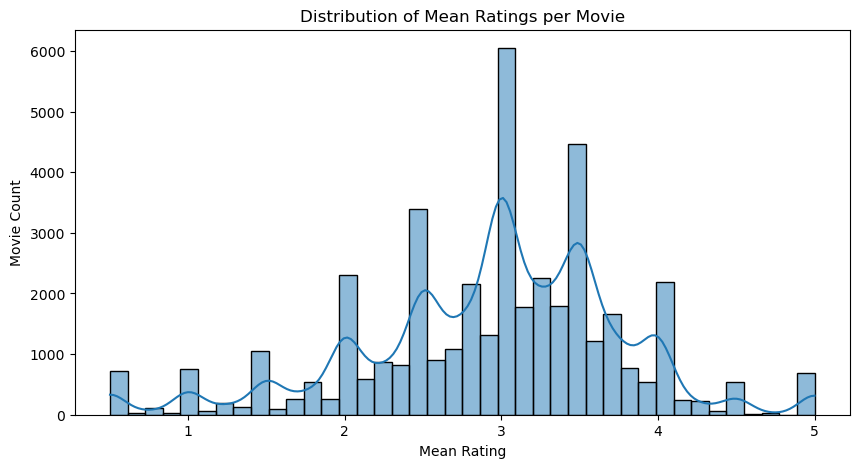

In [3]:
from modeling.utils.eda import explore_user_ratings

# 필요할 때 이렇게 사용: explore_user_ratings(df_ratings)
explore_user_ratings(df_ratings)

In [4]:
# Sparsity 계산
n_users = df_ratings['user_id'].nunique()
n_movies = df_ratings['movie_id'].nunique()
n_ratings = len(df_ratings)

# 전체 가능한 셀의 수
total_possible_ratings = n_users * n_movies

# Density (밀도) = 실제로 채워진 비율
density = n_ratings / total_possible_ratings

# Sparsity (희소성) = 비어있는 비율
sparsity = 1 - density

print(f"\n=== Sparsity 분석 ===")
print(f"전체 사용자 수: {n_users:,}")
print(f"전체 영화 수: {n_movies:,}")
print(f"실제 평점 수: {n_ratings:,}")
print(f"전체 가능한 평점 수: {total_possible_ratings:,}")
print(f"\nDensity (밀도): {density*100:.4f}%")
print(f"Sparsity (희소성): {sparsity*100:.4f}%")
print(f"\n해석: 전체 사용자-영화 조합 중 {sparsity*100:.4f}%가 비어있습니다.")


=== Sparsity 분석 ===
전체 사용자 수: 2,442
전체 영화 수: 42,176
실제 평점 수: 1,979,622
전체 가능한 평점 수: 102,993,792

Density (밀도): 1.9221%
Sparsity (희소성): 98.0779%

해석: 전체 사용자-영화 조합 중 98.0779%가 비어있습니다.


sparsity가 너무 높나?
- 도메인 특성을 생각해보면 높은 건 아니다.

중요한 건 데이터의 양
- 데이터 크기가 충분한지
- 사용자별 평점 개수, 영화별 평점 개수가 충분한지 (각 사용자 최소 10~20개, 각 영화 5~10개)

MF는 sparisty에 강함
- 95~99%도 괜찮다고 함

In [5]:
from modeling.utils.data import filter_by_min_counts

# 필터링 기준 설정
MIN_USER_RATINGS = 30
MIN_MOVIE_RATINGS = 10

df_filtered = filter_by_min_counts(df_ratings, MIN_USER_RATINGS, MIN_MOVIE_RATINGS)

# 필터링 후 Sparsity 계산
n_users_filtered = df_filtered['user_id'].nunique()
n_movies_filtered = df_filtered['movie_id'].nunique()
n_ratings_filtered = len(df_filtered)
total_possible_filtered = n_users_filtered * n_movies_filtered
sparsity_filtered = 1 - (n_ratings_filtered / total_possible_filtered)

print(f"\n=== Sparsity 비교 ===")
print(f"필터링 전 Sparsity: {sparsity*100:.4f}%")
print(f"필터링 후 Sparsity: {sparsity_filtered*100:.4f}%")
print(f"Sparsity 감소: {(sparsity - sparsity_filtered)*100:.4f}%p")


[필터링 전] 사용자 수: 2,442명, 영화 수: 42,176개
[필터 적용] min_user_ratings: 30, min_movie_ratings: 10
조건 통과 사용자 수: 2,400명, 조건 통과 영화 수: 12,746개
[필터링 후] 사용자 수: 2,400명, 영화 수: 12,746개
필터링된 평점 수: 1,903,992개 (제거: 75,630개)

=== Sparsity 비교 ===
필터링 전 Sparsity: 98.0779%
필터링 후 Sparsity: 93.7759%
Sparsity 감소: 4.3021%p



[사용자별 평점 수 통계(describe)]
            count
count  2400.00000
mean    793.33000
std     617.16271
min      31.00000
25%     367.00000
50%     657.50000
75%    1063.25000
max    5931.00000


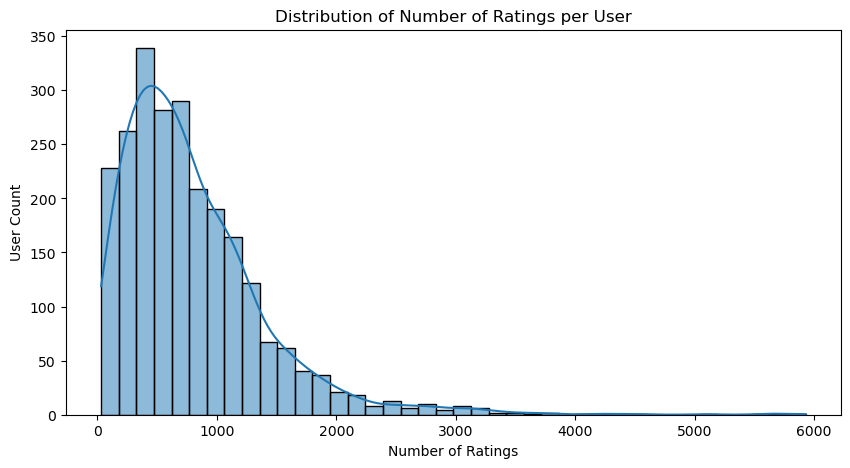


[사용자별 평균 평점 통계(describe)]
       mean_rating
count  2400.000000
mean      3.409003
std       0.368415
min       1.585910
25%       3.197034
50%       3.423262
75%       3.627781
max       5.000000


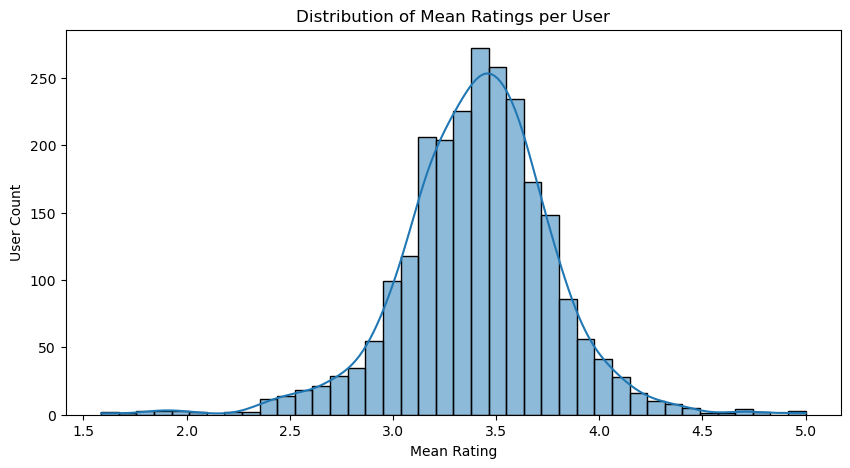


[영화별 평점 수 통계(describe)]
              count
count  12746.000000
mean     149.379570
std      261.430818
min        9.000000
25%       18.000000
50%       44.000000
75%      144.000000
max     1976.000000


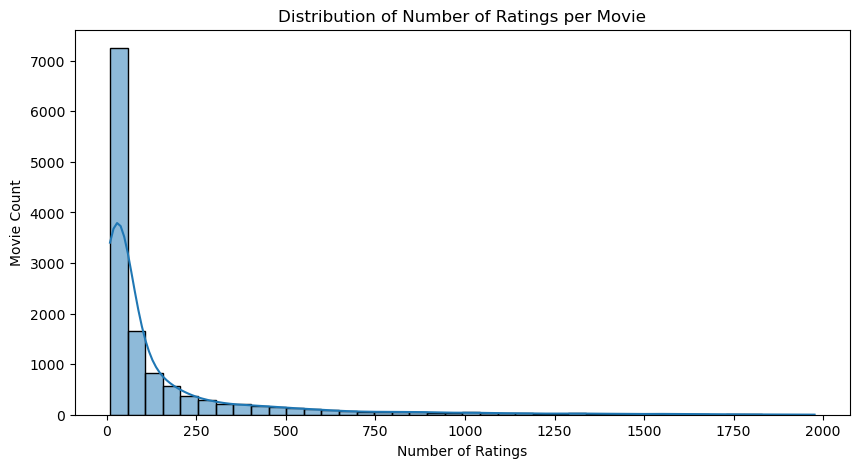


[영화별 평균 평점 통계(describe)]
        mean_rating
count  12746.000000
mean       3.099493
std        0.573295
min        0.558824
25%        2.764706
50%        3.166667
75%        3.513289
max        4.450000


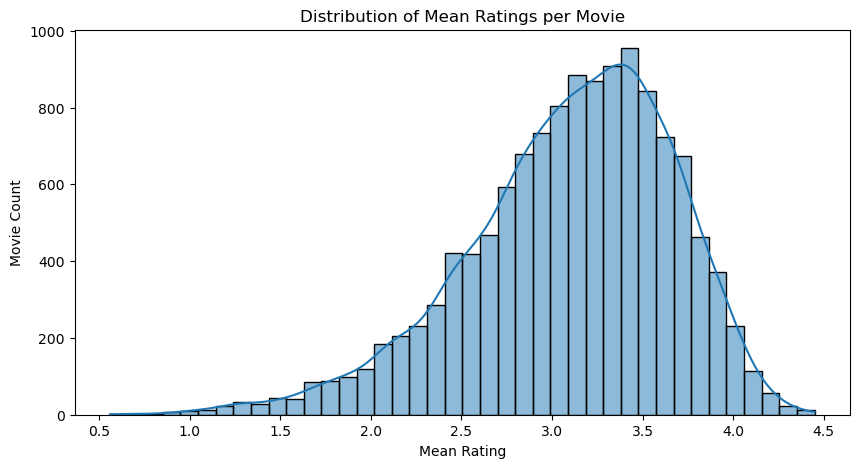

In [6]:
explore_user_ratings(df_filtered)

## 데이터 해석

1. 최소 평가 개수가 30개가 넘는데, 평균평점이 1.5이거나 5.0인 사람이 있네. 되게 특이하다. 다음과 같은 케이스가 있지 않을까?
   - 싫은 것만 혹은 좋은 것만 평점을 남기는 유저
   - 호불호가 굉장히 확실한 유저
2. 내가 고객의 평가정보를 긁어왔기 때문에 cold movie가 훨씬 많음

# Preprocessing

In [7]:
df = load_ratings_data()
filtered_df = filter_by_min_counts(df, min_user_ratings=30, min_movie_ratings=10)


[필터링 전] 사용자 수: 2,442명, 영화 수: 42,176개
[필터 적용] min_user_ratings: 30, min_movie_ratings: 10
조건 통과 사용자 수: 2,400명, 조건 통과 영화 수: 12,746개
[필터링 후] 사용자 수: 2,400명, 영화 수: 12,746개
필터링된 평점 수: 1,903,992개 (제거: 75,630개)


In [9]:
from modeling.utils.data import preprocess_id_mapping

# 실제 사용
df_filtered, id_mapping = preprocess_id_mapping(df_filtered)


=== 전처리: ID 매핑 ===

사용자 매핑: 2,400명
  - 원본 예시: [('17ovV0EW1xzyn', 0), ('17ovV0eYlxzyn', 1), ('17ovV16Y2qzyn', 2)]

영화 매핑: 12,746개
  - 원본 예시: [('m15G1rO', 0), ('m15G2Bd', 1), ('m15G3D5', 2)]

전처리된 데이터:
      user_id  user_idx movie_id  movie_idx   movie_title  rating
ZBm5R0Mj7qd46      1736  m5XKVDL       1413         양자물리학     3.0
ZBm5R0Mj7qd46      1736  mdKpyBk      11372      성적표의 김민영     3.0
ZBm5R0Mj7qd46      1736  mWya9Bx       9582           한 채     3.0
ZBm5R0Mj7qd46      1736  m5nXwBD       3088  킹덤 3: 운명의 불꽃     3.0
ZBm5R0Mj7qd46      1736  m53mGAw        406 킹덤 2: 아득한 대지로     3.0
ZBm5R0Mj7qd46      1736  mdB7Joq      10662      글래디에이터 Ⅱ     2.5
ZBm5R0Mj7qd46      1736  m5nwAgn       3128            킹덤     3.0
ZBm5R0Mj7qd46      1736  mWq1YVl       8679            미망     3.0
ZBm5R0Mj7qd46      1736  mWyaQ9y       9603           달팽이     3.0
ZBm5R0Mj7qd46      1736  mOAk0kl       5288         범죄도시2     3.0

=== 최종 데이터 통계 ===
사용자 수: 2,400명
영화 수: 12,746개
평점 수: 1,903,992개
평점 범위: 0.

# Train/Test Split & SVD Modeling

In [26]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split # surprise 내부에서 user-item 겹치기를 보장
from surprise import accuracy

In [27]:
# Surprise Dataset 준비
# Surprise 라이브러리는 (user_id, item_id, rating) 형태의 데이터를 요구합니다

print("=== Surprise Dataset 준비 ===\n")

# Reader 객체 생성 (평점 범위 지정)
reader = Reader(rating_scale=(0.5, 5.0))

# DataFrame을 Surprise Dataset으로 변환
# user_id와 movie_id를 그대로 사용 (매핑된 idx가 아닌 원본 ID 사용)
data = Dataset.load_from_df(
    df_filtered[['user_id', 'movie_id', 'rating']], 
    reader
)

print(f"데이터셋 생성 완료")
print(f"- 총 평점 수: {len(df_filtered)}")
print(f"- 평점 범위: 0.5 ~ 5.0")


=== Surprise Dataset 준비 ===

데이터셋 생성 완료
- 총 평점 수: 1903992
- 평점 범위: 0.5 ~ 5.0


In [29]:
# Train/Test Split
# test_size=0.2 -> 80% train, 20% test
print("=== Train/Test Split ===\n")

trainset, testset = train_test_split(data, test_size=0.2, random_state=42) # surprise.model_selection

print(f"Train set size: {trainset.n_ratings:,}")
print(f"Test set size: {len(testset):,}")
print(f"\nTrain set 통계:")
print(f"  - 사용자 수: {trainset.n_users}")
print(f"  - 영화 수: {trainset.n_items}")
print(f"  - 평점 수: {trainset.n_ratings}")
print(f"  - 전체 셀 수: {trainset.n_users * trainset.n_items:,}")
print(f"  - Train Sparsity: {(1 - trainset.n_ratings / (trainset.n_users * trainset.n_items))*100:.2f}%")

# --- user-item 겹치는 정도 확인 코드 추가 ---
# testset은 (uid, iid, rating) 튜플들의 리스트임
train_users = set(trainset._raw2inner_id_users.keys())
train_items = set(trainset._raw2inner_id_items.keys())
test_users = set([uid for (uid, _, _) in testset])
test_items = set([iid for (_, iid, _) in testset])

user_overlap = len(train_users & test_users) / len(test_users) * 100
item_overlap = len(train_items & test_items) / len(test_items) * 100

print("\n[User/Item Overlap between Train and Test set]")
print(f"- Test set 사용자 중, Train set에서 본 사용자 비율: {user_overlap:.2f}% ({len(train_users & test_users)}/{len(test_users)})")
print(f"- Test set 아이템 중, Train set에서 본 아이템 비율: {item_overlap:.2f}% ({len(train_items & test_items)}/{len(test_items)})")


=== Train/Test Split ===

Train set size: 1,523,193
Test set size: 380,799

Train set 통계:
  - 사용자 수: 2400
  - 영화 수: 12746
  - 평점 수: 1523193
  - 전체 셀 수: 30,590,400
  - Train Sparsity: 95.02%

[User/Item Overlap between Train and Test set]
- Test set 사용자 중, Train set에서 본 사용자 비율: 100.00% (2400/2400)
- Test set 아이템 중, Train set에서 본 아이템 비율: 100.00% (12545/12545)


In [30]:
# SVD 모델 생성 및 학습
print("=== SVD 모델 학습 ===\n")

# SVD 하이퍼파라미터 설정
svd_params = {
    'n_factors': 50,      # latent factor 개수
    'n_epochs': 20,        # 학습 반복 횟수
    'lr_all': 0.005,       # learning rate
    'reg_all': 0.02,       # regularization term
    'random_state': 42,    # 재현성을 위한 시드값
    'verbose': True        # 학습 진행 상황 출력
}

print(f"SVD 파라미터:")
for key, value in svd_params.items():
    print(f"  - {key}: {value}")

print("\n학습 시작...\n")

# SVD 모델 생성 및 학습
svd_model = SVD(**svd_params)
svd_model.fit(trainset)

print("\n✅ 학습 완료!")


=== SVD 모델 학습 ===

SVD 파라미터:
  - n_factors: 50
  - n_epochs: 20
  - lr_all: 0.005
  - reg_all: 0.02
  - random_state: 42
  - verbose: True

학습 시작...

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19

✅ 학습 완료!


In [23]:
# 모델 평가
print("=== 모델 평가 ===\n")

# Test set에 대한 예측
print("Test set 평가:")
test_predictions = svd_model.test(testset)
test_rmse = accuracy.rmse(test_predictions, verbose=True)
test_mae = accuracy.mae(test_predictions, verbose=True)

# Train set에 대한 평가 (overfitting 확인용)
print("\n\nTrain set 평가:")
train_testset = trainset.build_testset()
train_predictions = svd_model.test(train_testset)
train_rmse = accuracy.rmse(train_predictions, verbose=True)
train_mae = accuracy.mae(train_predictions, verbose=True)

# 결과 요약
print("\n\n=== 평가 결과 요약 ===")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")
print(f"Train MAE:  {train_mae:.4f}")
print(f"Test MAE:   {test_mae:.4f}")

# Overfitting 체크
if test_rmse - train_rmse > 0.1:
    print("\n⚠️  경고: Test RMSE가 Train RMSE보다 유의미하게 높습니다. Overfitting 가능성이 있습니다.")
elif test_rmse - train_rmse < 0.05:
    print("\n✅ Train과 Test 성능이 비슷합니다. 적절한 일반화가 이루어졌습니다.")
else:
    print("\n✅ Train과 Test 성능 차이가 적절한 수준입니다.")


=== 모델 평가 ===

Test set 평가:
RMSE: 0.6929
MAE:  0.5240


Train set 평가:
RMSE: 0.6219
MAE:  0.4755


=== 평가 결과 요약 ===
Train RMSE: 0.6219
Test RMSE:  0.6929
Train MAE:  0.4755
Test MAE:   0.5240

✅ Train과 Test 성능 차이가 적절한 수준입니다.


In [24]:
test_predictions[:5]

[Prediction(uid='NP9vLD21Zv6kl', iid='m5xAwjW', r_ui=3.0, est=3.257355770581359, details={'was_impossible': False}),
 Prediction(uid='4WLxZalwW5roA', iid='mdjajwO', r_ui=3.5, est=3.0257042841005397, details={'was_impossible': False}),
 Prediction(uid='WwRqoazz05lzB', iid='m5YyDj5', r_ui=2.0, est=1.6162207962191326, details={'was_impossible': False}),
 Prediction(uid='ld0q0rky356Xn', iid='m5YEXw5', r_ui=3.5, est=3.661507672984144, details={'was_impossible': False}),
 Prediction(uid='6ADvGWBQzdvzZ', iid='mM5r2b5', r_ui=4.5, est=4.039923600564241, details={'was_impossible': False})]

In [18]:
train_testset[:5]

[('jae5WKpdV51P3', 'm5Qo97O', 3.0),
 ('jae5WKpdV51P3', 'mWz4Z0d', 4.0),
 ('jae5WKpdV51P3', 'm6dRLLW', 4.5),
 ('jae5WKpdV51P3', 'm5NVV9Y', 4.0),
 ('jae5WKpdV51P3', 'm5eZrzW', 2.5)]

## 추천 코드 짜기

In [60]:
from data_scraping.common.data_loader import load_movie_data

df_movies = load_movie_data()

In [66]:
import pandas as pd

user_id = 'ZBm5R0Mj7qd46'
n = 10

unseend_movie_ids = set(df_ratings['movie_id']) - set(df_ratings.loc[df_ratings['user_id'] == user_id, 'movie_id'])

predictions = []
for movie_id in unseend_movie_ids:
    pred = svd_model.predict(user_id, movie_id)
    predictions.append((movie_id, pred.est))

# movie_id로 타이틀 붙이기
reco = pd.DataFrame(predictions, columns=['movie_id','predicted_rating'])
reco = pd.merge(reco, df_movies, on='movie_id')

In [82]:
pd.merge(df_ratings.loc[df_ratings['user_id'] == user_id], df_movies, on='movie_id').sort_values(by='rating_x', ascending=False).head(10)

,user_id,movie_id,movie_title,rating_x,title,year,genre,country,runtime,rating_y,cast,plot,avg_score,popularity,review_count
1437,ZBm5R0Mj7qd46,m5N3o7W,디태치먼트,5.0,디태치먼트,2011.0,드라마,미국,1시간 38분,청불,"[('토니 케이', '감독'), ('애드리언 브로디', '주연 | 헨리 바스'), ...",새로운 학교에 배치된 교사 헨리는 학생들을 다루는데 능숙하지만 과거 힘들었던 기억 ...,3.9,9.4,4500+
1931,ZBm5R0Mj7qd46,mLOPNl5,랜드 앤 프리덤,5.0,랜드 앤 프리덤,1995.0,전쟁 드라마,"스페인, 독일, 영국",1시간 49분,15세,"[('켄 로치', '감독'), ('이안 하트', '주연'), ('로사나 파스토르',...",1994년 영국 리버풀의 한 시영 공립 주택. 한 노인이 심장마비로 병원 후송 중 ...,3.5,2027.0,100+
2715,ZBm5R0Mj7qd46,mJO1RPd,사랑의 블랙홀,5.0,사랑의 블랙홀,1993.0,코미디 판타지 로맨틱 코미디,미국,1시간 41분,15세,"[('해롤드 래미스', '감독'), ('빌 머레이', '주연 | 필'), ('앤디 ...",자고 일어나면 매일 똑같은 날 똑같은 장소라면 당신은 어떻게 하겠는가? 잘나가는 ...,3.9,11.2,3000+
2698,ZBm5R0Mj7qd46,mW9e41W,타이타닉호의 비극,5.0,타이타닉호의 비극,1958.0,재난 드라마,영국,2시간 3분,전체,"[('로이 베이커', '감독'), ('케네스 모어', '주연 | 2등 항해사 찰스 ...",모든 면에서 세계 최고를 자랑하며 영국인들에게 자부심을 주었던 타이타닉 호는 191...,3.9,93.0,10+
2964,ZBm5R0Mj7qd46,m2djpoW,미스 리틀 선샤인,5.0,미스 리틀 선샤인,2006.0,드라마 코미디,미국,1시간 41분,15세,"[('조나단 데이턴', '감독'), ('발레리 페리스', '감독'), ('그렉 키니...",또래 아이보다 통통한 몸매지만 유난히 미인대회에 집착하 올리브에게 캘리포니아 주에서...,3.9,12.7,4000+
2237,ZBm5R0Mj7qd46,mE5Dn0O,태극권,5.0,태극권,1993.0,코미디 액션,"홍콩, 미국",1시간 36분,15세,"[('원화평', '감독'), ('이연걸', '주연 | 장군보 장삼풍'), ('전소호...",정치적 혼란기인 원조말. 지방을 관활하던 태감들은 폭정으로 백성을 괴롭히고 있었다....,3.5,2.2,200+
2241,ZBm5R0Mj7qd46,m5Y6BjW,폴리스 스토리,5.0,폴리스 스토리,1985.0,액션 코미디 범죄 스릴러,홍콩,1시간 40분,15세,"[('성룡', '감독'), ('성룡', '주연 | 진가구'), ('장만옥', '조연...",홍콩 경찰청의 특수기동대 소속 진가구 순경(성룡)은 낙천적인 성격과 뛰어난 능력으로...,3.7,9.1,600+
2250,ZBm5R0Mj7qd46,mXOgG9O,로보캅,5.0,로보캅,1987.0,액션 범죄 SF 스릴러,미국,1시간 42분,12세,"[('폴 버호벤', '감독'), ('피터 웰러', '주연 | 머피 로보캅'), (...","멀지 않은 미래, 미국의 공업도시 디트로이트는 범죄 집단의 소굴이 되어가고, 시 경...",3.6,11.9,950+
2277,ZBm5R0Mj7qd46,m5ngq3W,뜨거운 것이 좋아,5.0,뜨거운 것이 좋아,1959.0,코미디 음악 로맨스 로맨틱 코미디,미국,2시간 00분,청불,"[('빌리 와일더', '감독'), ('마릴린 먼로', '주연 | 슈가'), ('토니...",색소폰 연주자인 조와 베이스 바이올린 연주자 제리는 갱단의 살인 장면을 우연히 목격...,3.9,1.7,900+
1254,ZBm5R0Mj7qd46,m5GXz42,라라랜드,5.0,라라랜드,2016.0,코미디 드라마 음악 뮤지컬 로맨스,미국,2시간 6분,12세,"[('데미언 셔젤', '감독'), ('라이언 고슬링', '주연 | 세바스찬'), (...","황홀한 사랑, 순수한 희망, 격렬한 열정… 이 곳에서 모든 감정이 폭발한다! 꿈을...",4.1,112.4,30000+


In [81]:
reco.sort_values(by='predicted_rating', ascending=False).head(10)

,movie_id,predicted_rating,title,year,genre,country,runtime,rating,cast,plot,avg_score,popularity,review_count
2492,m5aKVNO,4.473765,클로즈 업,1990.0,전기 범죄 드라마,이란,1시간 38분,12세,"[('압바스 키아로스타미', '감독'), ('후세인 사브지안', '주연 | 본인')...",버스에서 모흐센 마흐말바프의 책을 읽고 있는 실업자 알리 사브지안에게 어느 상류층 ...,4.2,2467.0,350+
8235,md6B3Ad,4.211683,대부 일대기,1992.0,드라마 범죄,미국,9시간 43분,전체,"[('프랜시스 포드 코폴라', '감독'), ('말론 브란도', '주연'), ('알 ...",None,4.4,6694.0,150+
9301,mOgBrY9,4.203027,빌리 엘리어트 뮤지컬 라이브,2014.0,코미디 드라마 음악 공연실황 뮤지컬,영국,2시간 59분,전체,"[('브렛 설리반', '감독'), ('스티븐 달드리', '감독'), ('엘리엇 한나...",가난한 탄광촌에서 파업시위에 열성인 아버지와 형 그리고 치매증세가 있는 할머니와 함...,4.1,2.2,450+
7370,mOkLgbg,4.164887,기생충 흑백판,2020.0,드라마,한국,2시간 11분,15세,"[('봉준호', '감독'), ('송강호', '주연 | 기택'), ('최우식', '주...",“폐 끼치고 싶진 않았어요” 전원백수로 살 길 막막하지만 사이는 좋은 기택(송강...,4.2,2.4,250+
2725,m5r0pVO,4.150933,12인의 노한 사람들,1997.0,드라마 범죄,미국,1시간 57분,전체,"[('윌리엄 프리드킨', '감독'), ('잭 레먼', '주연'), ('오시 데이비스...",아버지를 죽인 혐의로 기소된 라틴계 소년에 대한 유죄 평결 여부를 놓고 논쟁하는 1...,4.2,8788.0,200+
621,md7nK2O,4.131509,할복,1962.0,시대극 액션 드라마 미스터리,일본,2시간 14분,15세,"[('고바야시 마사키', '감독'), ('나카다이 타츠야', '주연 | 츠구모 한시...",인습과 전통에 대해 순응하는 일본 사회에 저항하는 메세지를 담은 작품. 사소한 잘못...,4.2,2423.0,300+
1276,mO0gZ9x,4.089796,레미제라블 25주년 라이브 공연,2010.0,드라마 음악 뮤지컬,영국,2시간 58분,전체,"[('닉 모리스', '감독'), ('알피 보', '주연 | 장발장'), ('놈 루이...",웅장한 인트로에서 마지막 무대의 감동까지 명불허전 뮤지컬 '레미제라블'의 25주년 ...,4.2,1.5,500+
2642,mOAZZvQ,4.084304,방파제,1962.0,단편 드라마 로맨스 SF,프랑스,28분,None,"[('크리스 마커', '감독'), ('엘렌 샤텔레인', '주연'), ('다보스 해니...",세계 제3차 대전이 발발한다. 파리의 오를레이 공항에 있는 한 산책로에서 다보스 헨...,4.0,3118.0,250+
9437,mW4Lxjl,4.065172,다시 태어나도 우리,2016.0,다큐멘터리,한국,1시간 35분,전체,"[('문창용', '감독'), ('전진', '감독'), ('파드마 앙뚜', '주연 |...","“약속해요, 언젠가 돌아와 다시 만나게 될 거라고…” 전생을 기억하는 조금 특별한 ...",4.0,7050.0,550+
738,mOo0ePd,4.065019,월레스와 그로밋 - 걸작선,1996.0,애니메이션 가족,영국,1시간 15분,전체,"[('닉 파크', '감독')]",None,4.0,10.0,500+


## 결과 해석 및 정리하기

SVD 모델 -> interaction data 에서 latent vector 추출을 효율적으로 하는 모델    
이를 통해 내가 가능한 건, 학습했던 유저 아이디에 대한 추천 결과를 뽑아볼 수 있음.

train-test split할 때 surprise 내부에서 user-item이 모두 포함되도록 짤라줌

확실히 interaction 만을 가지고 하다보니 영화의 meta-data가 포함되지 않는게 아쉽다.
- 미드를 좋아하는 유저라면, 미드를 좀 더 추천해주거나
- 특정 감독이나 배우를 좋아한다면, 아직 보지 않거나 관련된 영화를 추천해주거나

# Interaction으로 Item-Based Filtering 구현

**Item-Based Collaborative Filtering 원리:**
1. 영화 간의 유사도 계산 (user-item interaction 기반)
2. 사용자가 본 영화와 유사한 영화 찾기
3. 유사도 가중 평균으로 평점 예측

**구현 방식:**
- User-Item Matrix 생성
- 영화 간 코사인 유사도 계산
- Top-K 유사 영화 기반 평점 예측

In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import time

print("Item-Based Filtering 라이브러리 import 완료")

Item-Based Filtering 라이브러리 import 완료


In [5]:
import sys
from pathlib import Path

# modeling 디렉토리를 Python 경로에 추가
modeling_dir = Path().absolute().parent
if str(modeling_dir) not in sys.path:
    sys.path.insert(0, str(modeling_dir))

from utils import data

df = data.load_data()
df_filtered = data.filter_by_min_counts(df)
df_preprocessed, id_mapping = data.preprocess_id_mapping(df_filtered)


사용자 평점 데이터 로딩 중...
평점 데이터: 909,664개
고유 사용자 수: 1,147명
고유 영화 수: 32,843개

[필터링 전] 사용자 수: 1,147명, 영화 수: 32,843개
[필터 적용] min_user_ratings: 30, min_movie_ratings: 10
조건 통과 사용자 수: 1,121명, 조건 통과 영화 수: 9,222개
[필터링 후] 사용자 수: 1,121명, 영화 수: 9,222개
필터링된 평점 수: 851,330개 (제거: 58,334개)

=== 전처리: ID 매핑 ===

사용자 매핑: 1,121명
  - 원본 예시: [('17ovV0EW1xzyn', 0), ('17ovV1eblqzyn', 1), ('17ovV1r2Pqzyn', 2)]

영화 매핑: 9,222개
  - 원본 예시: [('m15G1rO', 0), ('m15G2Bd', 1), ('m15G3D5', 2)]

전처리된 데이터:
      user_id  user_idx movie_id  movie_idx    movie_title  rating
ZBm5R0Mj7qd46       812  m5XKVDL       1027          양자물리학     3.0
ZBm5R0Mj7qd46       812  mdKpyBk       8166       성적표의 김민영     3.0
ZBm5R0Mj7qd46       812  mdB7Joq       7649       글래디에이터 Ⅱ     2.5
ZBm5R0Mj7qd46       812  m5nwAgn       2244             킹덤     3.0
ZBm5R0Mj7qd46       812  mWq1YVl       6276             미망     3.0
ZBm5R0Mj7qd46       812  mOAk0kl       3895          범죄도시2     3.0
ZBm5R0Mj7qd46       812  m5Q9ywD        825 그대들은 어떻게 살 것인가  

In [6]:
# Step 1: Train/Test 데이터 분리 (item-based용)
print("=== Item-Based Filtering을 위한 데이터 분리 ===\n")

from sklearn.model_selection import train_test_split as sklearn_train_test_split

# 80:20 분할
train_df, test_df = sklearn_train_test_split(
    df_preprocessed, 
    test_size=0.2, 
    random_state=42
)

print(f"Train 데이터: {len(train_df):,}개")
print(f"Test 데이터: {len(test_df):,}개")
print(f"Train 사용자 수: {train_df['user_idx'].nunique()}")
print(f"Train 영화 수: {train_df['movie_idx'].nunique()}")
print(f"Test 사용자 수: {test_df['user_idx'].nunique()}")
print(f"Test 영화 수: {test_df['movie_idx'].nunique()}")

=== Item-Based Filtering을 위한 데이터 분리 ===

Train 데이터: 681,064개
Test 데이터: 170,266개
Train 사용자 수: 1121
Train 영화 수: 9222
Test 사용자 수: 1121
Test 영화 수: 9075


In [7]:
# Step 2: User-Item Matrix 생성 (Train 데이터 기반)
print("=== User-Item Matrix 생성 ===\n")

n_users = df_preprocessed['user_idx'].nunique()
n_movies = df_preprocessed['movie_idx'].nunique()

# Sparse Matrix 생성 (메모리 효율적)
user_item_matrix = csr_matrix(
    (train_df['rating'], (train_df['user_idx'], train_df['movie_idx'])),
    shape=(n_users, n_movies)
)

print(f"Matrix Shape: {user_item_matrix.shape} (users x movies)")
print(f"Total cells: {n_users * n_movies:,}")
print(f"Non-zero cells: {user_item_matrix.nnz:,}")
print(f"Sparsity: {(1 - user_item_matrix.nnz / (n_users * n_movies)) * 100:.2f}%")
print(f"Memory size: {user_item_matrix.data.nbytes / (1024**2):.2f} MB")


=== User-Item Matrix 생성 ===

Matrix Shape: (1121, 9222) (users x movies)
Total cells: 10,337,862
Non-zero cells: 681,064
Sparsity: 93.41%
Memory size: 5.20 MB


In [8]:
# Step 3: Item-Item 유사도 계산 (코사인 유사도)
print("=== Item-Item 유사도 계산 ===\n")
print("계산 중... (시간이 다소 걸릴 수 있습니다)")

start_time = time.time()

# User-Item Matrix를 전치하여 Item-User Matrix로 변환
item_user_matrix = user_item_matrix.T

# 코사인 유사도 계산 (item x item)
item_similarity = cosine_similarity(item_user_matrix, dense_output=False)

elapsed_time = time.time() - start_time

print(f"\n✅ 유사도 계산 완료!")
print(f"Item Similarity Matrix Shape: {item_similarity.shape} (movies x movies)")
print(f"계산 시간: {elapsed_time:.2f}초")
print(f"Non-zero similarities: {item_similarity.nnz:,}")
print(f"Memory size: {item_similarity.data.nbytes / (1024**2):.2f} MB")


=== Item-Item 유사도 계산 ===

계산 중... (시간이 다소 걸릴 수 있습니다)

✅ 유사도 계산 완료!
Item Similarity Matrix Shape: (9222, 9222) (movies x movies)
계산 시간: 1.57초
Non-zero similarities: 68,435,670
Memory size: 522.12 MB


In [9]:
# item_similarity 샘플 10개만 확인하려면 (dense하지 않은 형태, 즉 nonzero만)
from random import sample
import numpy as np

# 아이템 개수 N
n_movies = item_similarity.shape[0]
# 무작위 movie_idx 10개 뽑기
sample_movie_idx = sample(range(n_movies), 10)

for idx in sample_movie_idx:
    # 해당 영화와 다른 영화들과의 유사도 중 nonzero만 (즉, 실제로 유사한 것만)
    sim_row = item_similarity[idx].tocoo()
    print(f"\n[movie_idx={idx}] nonzero similarity count: {sim_row.nnz}")
    # 최대 5개만 프린트 (index, similarity)
    shown = 0
    for m_idx, sim in zip(sim_row.col, sim_row.data):
        print(f"  -> movie_idx={m_idx}, similarity={sim:.4f}")
        shown += 1
        if shown >= 5:
            break


[movie_idx=8428] nonzero similarity count: 9220
  -> movie_idx=3758, similarity=0.0192
  -> movie_idx=9109, similarity=0.0252
  -> movie_idx=2882, similarity=0.0441
  -> movie_idx=2055, similarity=0.0016
  -> movie_idx=2539, similarity=0.0370

[movie_idx=765] nonzero similarity count: 7393
  -> movie_idx=9119, similarity=0.0315
  -> movie_idx=9087, similarity=0.0196
  -> movie_idx=8669, similarity=0.0329
  -> movie_idx=7448, similarity=0.0353
  -> movie_idx=7034, similarity=0.0350

[movie_idx=9164] nonzero similarity count: 6640
  -> movie_idx=9215, similarity=0.0574
  -> movie_idx=9206, similarity=0.0424
  -> movie_idx=9194, similarity=0.0633
  -> movie_idx=9175, similarity=0.0388
  -> movie_idx=9174, similarity=0.0572

[movie_idx=305] nonzero similarity count: 5800
  -> movie_idx=9176, similarity=0.0171
  -> movie_idx=9131, similarity=0.0336
  -> movie_idx=9046, similarity=0.0189
  -> movie_idx=9023, similarity=0.0238
  -> movie_idx=8849, similarity=0.0288

[movie_idx=450] nonzero s

In [10]:
# Step 4: Item-Based 예측 함수 구현
def predict_item_based(user_idx, movie_idx, user_item_matrix, item_similarity, k=50):
    """
    Item-Based Collaborative Filtering 예측
    
    Args:
        user_idx: 사용자 인덱스
        movie_idx: 영화 인덱스
        user_item_matrix: User-Item 평점 행렬
        item_similarity: Item-Item 유사도 행렬
        k: Top-K 유사 아이템 개수
    
    Returns:
        predicted_rating: 예측 평점
    """
    # 사용자가 평가한 영화들
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items = np.where(user_ratings > 0)[0]
    
    if len(rated_items) == 0:
        # 사용자가 아무것도 평가하지 않았으면 전체 평균 반환
        return user_item_matrix.data.mean()
    
    # 타겟 영화와의 유사도
    similarities = item_similarity[movie_idx].toarray().flatten()
    
    # 사용자가 평가한 영화들 중에서만 유사도 추출
    sim_scores = similarities[rated_items]
    user_ratings_filtered = user_ratings[rated_items]
    
    # 유사도가 0보다 큰 것만 선택
    valid_mask = sim_scores > 0
    sim_scores = sim_scores[valid_mask]
    user_ratings_filtered = user_ratings_filtered[valid_mask]
    
    if len(sim_scores) == 0:
        # 유사한 영화가 없으면 사용자의 평균 평점 반환
        return user_ratings[rated_items].mean()
    
    # Top-K 유사 아이템 선택
    if len(sim_scores) > k:
        top_k_idx = np.argsort(sim_scores)[-k:]
        sim_scores = sim_scores[top_k_idx]
        user_ratings_filtered = user_ratings_filtered[top_k_idx]
    
    # 유사도 가중 평균
    if sim_scores.sum() == 0:
        return user_ratings_filtered.mean()
    
    predicted = np.dot(sim_scores, user_ratings_filtered) / sim_scores.sum()
    
    # 평점 범위 제한 (0.5 ~ 5.0)
    return np.clip(predicted, 0.5, 5.0)

print("✅ Item-Based 예측 함수 정의 완료")


✅ Item-Based 예측 함수 정의 완료


In [11]:
# Step 5: Test Set 평가
print("=== Item-Based Filtering 평가 ===\n")
print("예측 중... (시간이 다소 걸릴 수 있습니다)")

start_time = time.time()

# Test 데이터에 대한 예측
predictions = []
actuals = []

# 샘플링 (전체 테스트 데이터가 너무 크면 샘플링)
test_sample = test_df.sample(n=min(10000, len(test_df)), random_state=42)

for idx, row in test_sample.iterrows():
    user_idx = row['user_idx']
    movie_idx = row['movie_idx']
    actual_rating = row['rating']
    
    pred_rating = predict_item_based(
        user_idx, movie_idx, user_item_matrix, item_similarity, k=50
    )
    
    predictions.append(pred_rating)
    actuals.append(actual_rating)
    
    # 진행 상황 출력 (1000개마다)
    if len(predictions) % 1000 == 0:
        print(f"진행: {len(predictions)}/{len(test_sample)}")

predictions = np.array(predictions)
actuals = np.array(actuals)

elapsed_time = time.time() - start_time

print(f"\n✅ 예측 완료!")
print(f"예측 시간: {elapsed_time:.2f}초")
print(f"예측 개수: {len(predictions):,}개")


=== Item-Based Filtering 평가 ===

예측 중... (시간이 다소 걸릴 수 있습니다)
진행: 1000/10000
진행: 2000/10000
진행: 3000/10000
진행: 4000/10000
진행: 5000/10000
진행: 6000/10000
진행: 7000/10000
진행: 8000/10000
진행: 9000/10000
진행: 10000/10000

✅ 예측 완료!
예측 시간: 1.59초
예측 개수: 10,000개


In [12]:
# Step 6: 평가 지표 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print("\n=== Item-Based Filtering 성능 ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

# 예측값 분포 확인
print(f"\n예측값 통계:")
print(f"  - 최소값: {predictions.min():.2f}")
print(f"  - 최대값: {predictions.max():.2f}")
print(f"  - 평균: {predictions.mean():.2f}")
print(f"  - 표준편차: {predictions.std():.2f}")

print(f"\n실제값 통계:")
print(f"  - 평균: {actuals.mean():.2f}")
print(f"  - 표준편차: {actuals.std():.2f}")

# SVD와 비교
print(f"\n=== SVD와 비교 ===")
# print(f"SVD Test RMSE:       {test_rmse:.4f}")
print(f"Item-Based RMSE:     {rmse:.4f}")
# print(f"차이:                {abs(test_rmse - rmse):.4f}")

# if rmse < test_rmse:
#     print("✅ Item-Based가 SVD보다 성능이 좋습니다!")
# else:
#     print("⚠️  SVD가 Item-Based보다 성능이 좋습니다.")



=== Item-Based Filtering 성능 ===
RMSE: 0.8326
MAE:  0.6303

예측값 통계:
  - 최소값: 0.80
  - 최대값: 5.00
  - 평균: 3.60
  - 표준편차: 0.49

실제값 통계:
  - 평균: 3.32
  - 표준편차: 0.97

=== SVD와 비교 ===
Item-Based RMSE:     0.8326


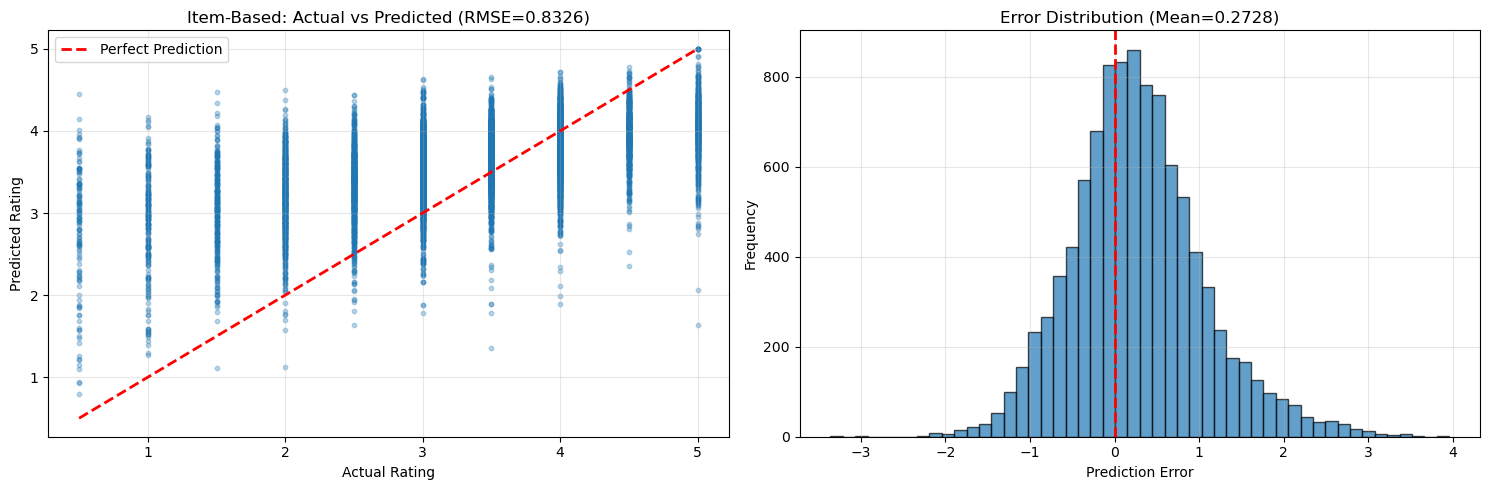

오차 통계:
  - 평균 오차: 0.2728
  - 오차 표준편차: 0.7867


In [13]:
# Step 7: 예측 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 예측값 vs 실제값 산점도
axes[0].scatter(actuals, predictions, alpha=0.3, s=10)
axes[0].plot([0.5, 5.0], [0.5, 5.0], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Item-Based: Actual vs Predicted (RMSE={rmse:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 오차 분포
errors = predictions - actuals
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Error Distribution (Mean={errors.mean():.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"오차 통계:")
print(f"  - 평균 오차: {errors.mean():.4f}")
print(f"  - 오차 표준편차: {errors.std():.4f}")


In [14]:
# Step 8: 특정 사용자에게 영화 추천하기
def recommend_movies_item_based(user_idx, user_item_matrix, item_similarity, 
                                 idx_to_movie, df_filtered, top_n=10, k=50):
    """
    Item-Based Filtering으로 사용자에게 영화 추천
    
    Args:
        user_idx: 사용자 인덱스
        user_item_matrix: User-Item 평점 행렬
        item_similarity: Item-Item 유사도 행렬
        idx_to_movie: 영화 인덱스 -> 영화 ID 매핑
        df_filtered: 영화 정보가 포함된 DataFrame
        top_n: 추천할 영화 개수
        k: 유사 아이템 개수
    
    Returns:
        recommendations: 추천 영화 리스트 (영화 정보 포함)
    """
    # 사용자가 평가한 영화들
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items = np.where(user_ratings > 0)[0]
    
    # 사용자가 평가하지 않은 영화들
    unrated_items = np.where(user_ratings == 0)[0]
    
    # 각 영화에 대한 예측 평점 계산
    predictions = []
    for movie_idx in unrated_items:
        pred_rating = predict_item_based(
            user_idx, movie_idx, user_item_matrix, item_similarity, k=k
        )
        predictions.append((movie_idx, pred_rating))
    
    # 예측 평점 기준으로 정렬
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Top-N 추천
    top_recommendations = predictions[:top_n]
    
    # 추천 결과를 DataFrame으로 변환
    recommendations = []
    for movie_idx, pred_rating in top_recommendations:
        movie_id = idx_to_movie[movie_idx]
        movie_info = df_filtered[df_filtered['movie_idx'] == movie_idx].iloc[0]
        recommendations.append({
            'movie_idx': movie_idx,
            'movie_id': movie_id,
            'movie_title': movie_info['movie_title'],
            'predicted_rating': pred_rating
        })
    
    return pd.DataFrame(recommendations)

print("✅ 추천 함수 정의 완료")


✅ 추천 함수 정의 완료


In [15]:
import pandas as pd

# 예시: 특정 사용자에게 추천
test_user_idx = 0

print(f"=== 사용자 {test_user_idx}에게 Item-Based 추천 ===\n")

# 사용자가 높은 평점을 준 영화들
user_ratings = user_item_matrix[test_user_idx].toarray().flatten()
rated_items = np.where(user_ratings > 0)[0]
high_rated = [(idx, user_ratings[idx]) for idx in rated_items]
high_rated.sort(key=lambda x: x[1], reverse=True)

print("사용자가 높게 평가한 영화 Top 5:")
for i, (movie_idx, rating) in enumerate(high_rated[:5], 1):
    movie_id = id_mapping.idx_to_movie[movie_idx]
    movie_title = df_preprocessed[df_preprocessed['movie_idx'] == movie_idx].iloc[0]['movie_title']
    print(f"{i}. {movie_title} - 평점: {rating:.1f}")

print("\n추천 영화 생성 중...")
recommendations = recommend_movies_item_based(
    test_user_idx, user_item_matrix, item_similarity, 
    id_mapping.idx_to_movie, df_preprocessed, top_n=10, k=50
)

print("\n추천 영화 Top 10:")
display(recommendations)

=== 사용자 0에게 Item-Based 추천 ===

사용자가 높게 평가한 영화 Top 5:
1. 봄날은 간다 - 평점: 5.0
2. 제로 다크 서티 - 평점: 5.0
3. 스포트라이트 - 평점: 5.0
4. 아가씨 - 평점: 5.0
5. 미스 슬로운 - 평점: 5.0

추천 영화 생성 중...

추천 영화 Top 10:


,movie_idx,movie_id,movie_title,predicted_rating
0,5218,mOo0P9a,우리들,4.171201
1,7940,mdEwEgW,멋진 하루,4.164467
2,8980,mnWJ03d,아메리칸 뷰티,4.161327
3,5441,mV53xjW,존 말코비치 되기,4.151361
4,2985,mLOPXO6,밀양,4.146694
5,9038,mpWpBad,파수꾼,4.143663
6,2561,m5xMxbW,만추,4.137786
7,5107,mOl4nEg,지금은맞고그때는틀리다,4.136492
8,3013,mM5rDjO,펀치 드렁크 러브,4.135869
9,2336,m5rQGMm,블루 재스민,4.131287


In [16]:
def find_similar_movies(movie_id, item_similarity, id_mapping, df_preprocessed, top_n=10):
    """
    특정 영화와 유사한 영화들을 찾는 함수
    
    Args:
        movie_id: 찾고자 하는 영화의 ID (문자열)
        item_similarity: Item-Item 유사도 행렬 (movie_idx x movie_idx)
        id_mapping: ID 매핑 객체 (movie_to_idx, idx_to_movie 포함)
        df_preprocessed: 영화 정보가 포함된 DataFrame
        top_n: 반환할 유사 영화 개수
    
    Returns:
        similar_movies_df: 유사한 영화 정보 DataFrame
    """
    # movie_id가 존재하는지 확인
    if movie_id not in id_mapping.movie_to_idx:
        print(f"❌ 영화 ID '{movie_id}'를 찾을 수 없습니다.")
        return None
    
    # movie_id를 movie_idx로 변환
    movie_idx = id_mapping.movie_to_idx[movie_id]
    
    # 해당 영화 정보 출력
    movie_info = df_preprocessed[df_preprocessed['movie_id'] == movie_id].iloc[0]
    print(f"\n=== 기준 영화 ===")
    print(f"영화 ID: {movie_id}")
    print(f"영화 제목: {movie_info['movie_title']}")
    print(f"영화 인덱스: {movie_idx}")
    
    # 해당 영화와 모든 영화들 간의 유사도 추출
    similarities = item_similarity[movie_idx].toarray().flatten()
    
    # 유사도가 0보다 큰 영화들만 선택 (자기 자신 제외)
    similar_indices = []
    for idx, sim in enumerate(similarities):
        if idx != movie_idx and sim > 0:
            similar_indices.append((idx, sim))
    
    # 유사도 기준으로 정렬 (높은 순)
    similar_indices.sort(key=lambda x: x[1], reverse=True)
    
    # Top-N 선택
    top_similar = similar_indices[:top_n]
    
    if len(top_similar) == 0:
        print("\n⚠️ 유사한 영화를 찾을 수 없습니다.")
        return None
    
    # 결과를 DataFrame으로 변환
    similar_movies = []
    for rank, (similar_idx, similarity) in enumerate(top_similar, 1):
        similar_movie_id = id_mapping.idx_to_movie[similar_idx]
        similar_movie_info = df_preprocessed[df_preprocessed['movie_idx'] == similar_idx].iloc[0]
        
        similar_movies.append({
            'rank': rank,
            'movie_id': similar_movie_id,
            'movie_title': similar_movie_info['movie_title'],
            'similarity': similarity
        })
    
    similar_movies_df = pd.DataFrame(similar_movies)
    
    return similar_movies_df

print("✅ 영화 유사도 함수 정의 완료")

✅ 영화 유사도 함수 정의 완료


In [19]:
data.find_movie_id_by_title(movie_title='타이타닉', df=df_preprocessed)

,movie_idx,movie_id,movie_title
0,2868,mJ5x8x5,타이타닉
1,2256,m5r0koO,타이타닉
2,1000,m5X2xRp,그 남자는 타이타닉을 보고 싶지 않았다


In [23]:
find_similar_movies(movie_id='mJ5x8x5', item_similarity=item_similarity, id_mapping=id_mapping, df_preprocessed=df_preprocessed, top_n=10)


=== 기준 영화 ===
영화 ID: mJ5x8x5
영화 제목: 타이타닉
영화 인덱스: 2868


,rank,movie_id,movie_title,similarity
0,1,mW4L2XW,인셉션,0.662434
1,2,mO2p7x5,인터스텔라,0.652808
2,3,mO02n15,설국열차,0.650694
3,4,m6dRLWy,타짜,0.648985
4,5,mdEjNm5,겨울왕국,0.644768
5,6,mLOPKgW,트루먼 쇼,0.644197
6,7,mOPooYW,괴물,0.638024
7,8,mmOb3kd,해리포터와 마법사의 돌,0.636378
8,9,m5mQ9z5,"광해, 왕이 된 남자",0.636338
9,10,my5YGwO,센과 치히로의 행방불명,0.632402


# 결과 해석하기


예측결과가 생각보다 좋은데?